In [2]:
push!(LOAD_PATH, joinpath(Pkg.dir("SpectralClustering"), "docs"));

# Approximate embedding

## Spectral Gruping using  Nystrom Method
It is possible obtain a approximation of the laplacian eigenvectors evaluating the simmiliarty of a small set of elements and then approximating the remaining affinites. Let be   $A \subset X$ a subset of sampled patterns and let $B = V - A$ be the rest of the non sampled patterns.   $W_A$ is the simmilarity matrix derived from the data contained in $A$ and $L_A$ is the laplacian matrix of  $W_A$.
  $W_B$ and $L_B$ are the matrices corresponding to the affinities of the patterns of $A$ and $B$. It is possible define $L$ as:
$$
  W=\def\arraystretch{1.5}
  \begin{bmatrix}
    W_A & W_B \\
    W_B^T & W_C
  \end{bmatrix}
   L=\def\arraystretch{1.5}
  \begin{bmatrix}
    L_A & L_B \\
    L_B^T & L_C
  \end{bmatrix}
$$
  It can be obtained an approximation of $W$, called $\hat{W}$,  from  $A$ and   $B$:
  
$$
  \hat{W} = \bar{U}\Lambda \bar{U}^T
	      =  \begin{bmatrix} A   & B \\
				B^T & B^T A^{-1} B
		\end{bmatrix}
$$

  In order to obtain the eigenvectors of the approximate laplacian matrix,  $\hat{L} =  \hat{D}^{\frac{1}{2}} \hat{W}
  \hat{D}^{\frac{1}{2}}$,   $\hat{L_A}$ and  $\hat{L_B}$  have to be computed: 
$\hat{{L_A}_{ij}} = \frac{W_{A_{ij}}}{\sqrt{\hat{d}_i \hat{d}_j}}$ and $ \hat{{L_B}_{ij}}= \frac{W_{B_{ij}}}{\sqrt{\hat{d}_i \hat{d}_{j+|A|}}} $

 where $\hat{d} = \hat{W} \mathbf{1}$.  If $\hat{L_A}$ is positive definite, it is possible to find an approximation of the orthogonals eigevectors in a single step. Let be  $ S=\hat{L_{A}} + \hat{L_{A}}^{-\frac{1}{2}}\hat{L_{B}}\hat{L_{B}}^T
\hat{L_{A}}^{-\frac{1}{2}} $ and its diagonalization  $S=U_S \Lambda_S U_S^T$,   [Fowkles et al.](#fowlkes2004spectral)  showed that if the matrix $V$ is defined as

$$  
  V=\begin{bmatrix} \hat{L_A} \\ \hat{L_B}^T \end{bmatrix}
  \hat{L_A}^{-\frac{1}{2}} U_S \Lambda_S^{-\frac{1}{2}}  
$$

  $\hat{L}$ is diagonalized by  $V$ and by $\Lambda_S$ y $V^T V = I$

The `NystromMethod` type allows to obtain approximate eigenvectors. The following things have to be defined in order to instatiante this type:
- A method to sample points Landmark Selection.
- The number of points to be sampled.
- The simmilarity function between patterns.
- The number of eigevectors to obtain.

INFO: Recompiling stale cache file /home/luciano/.julia/lib/v0.6/ImageMagick.ji for module ImageMagick.


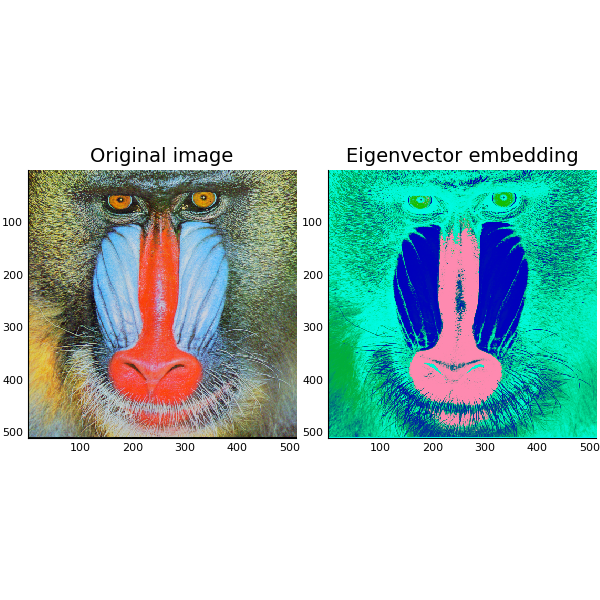

In [3]:
using TestImages,  Images, Plots, Clustering,  SpectralClustering, Distances, Extras 
pyplot()
function weight(i::Integer,j::Vector{<:Integer},pixel_i, neighbors_data)
    return vec(prod(exp.(-abs.(pixel_i[3:5].-neighbors_data[3:5,:])./(2*0.1^2)),1))
end
img                      = testimage("mandrill")
number_of_pixels         = size(img,1)*size(img,2)
number_of_sampled_points = round(Int,number_of_pixels * 0.005)
nvec                     = 3
knnconfig                = PixelNeighborhood(3)
nystrom                  = NystromMethod(
                              EvenlySpacedLandmarkSelection(),
                              number_of_sampled_points,
                              weight,
                              nvec,
                              false)
embedded_patterns        = embedding(nystrom, img)
img_embedded             = Extras.embedded_image(size(img), embedded_patterns)
plt1 = Plots.plot(img_embedded, title="Eigenvector embedding") 
plt2 = Plots.plot(img, title ="Original image")
Plots.plot(plt2, plt1, layout=(@layout grid(1,2)) , size=(600,600))

## DNCuts
In [Multiscale Combinatorial Grouping for Image Segmentation and Object Proposal Generation](#pont2017multiscale) the authors presented a a technique for approximating the eigenvectors in a very efficiently way.
Their algorithm is based in two observations:
- The eigenvectors of the Laplacian $L$ are the same as the eigenvectors of $A^2$
- The eigenvectors of a downsampled version of L should be similar to the eigenvectors of $L$.

The idea is to decimate the simmiliraty matrix to obtain $W[i,i]$. This matrix is obtained by removing the rows and columns corresponding to the pixels in every even column  and every even row of the image. The next step is propagate the affinities $W[i,i]$ by squaring the matrix. This procedure is carried for a few iterations. Then the eigenvectors of the last version of the decimated matrix is obtained. And finally the eigenvectors are upsampled to the original size. 

Their technique "is similar to Nystrom’s method for computing the eigenvectors of a subset of A, but our squaring-and-decimation procedure means that we do not depend on long-range connections between pixels."

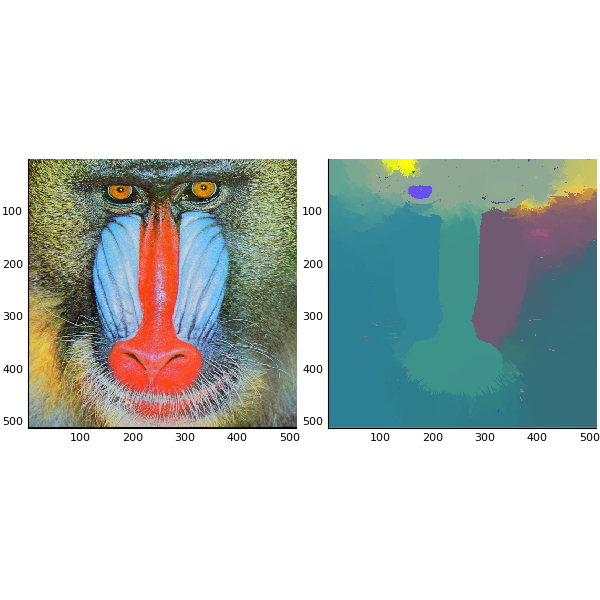

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [4]:
using Clustering, Images, TestImages, SpectralClustering,Distances,Extras, Plots, LightGraphs
pyplot()
function w(i::Integer, j::Vector{<:Integer}, pixel_j::Vector, neighbors_data::Matrix)
    col_sim = exp.(-(Distances.colwise(SqEuclidean(),pixel_j[3:5], neighbors_data[3:5,:])) / (2*(0.6^2)))
    return col_sim
end
img          = testimage("mandrill");
nconfig      = PixelNeighborhood(2);
graph        = create(nconfig,weight,  img);
nev          = 3
scales       = 2
dncuts       = DNCuts(scales, nev, size(img));
V            = embedding(dncuts, adjacency_matrix(graph));
img_embedded = Extras.embedded_image(size(img), V)
plt1 = Plots.plot(img_embedded)
plt2 = Plots.plot(img)
Plots.plot(plt2, plt1, layout=(@layout grid(1,2)) , size=(600,600))

In [5]:
using DocUtils
display("text/html",bibliography(["pont2017multiscale", "fowlkes2004spectral"]))


<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN">
 
 
 
 Bibliography 
 
 
 
 +017 
 Jordi Pont-Tuset, Pablo Arbelaez, Jonathan T Barron, Ferran Marques, and Jitendra Malik.
Multiscale combinatorial grouping for image segmentation and object proposal generation.
 IEEE transactions on pattern analysis and machine intelligence , 2017. 
 FBCM004 
 Charless Fowlkes, Serge Belongie, Fan Chung, and Jitendra Malik.
Spectral grouping using the nystrom method.
 IEEE transactions on pattern analysis and machine intelligence , 2004.